# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png)

##  Project Capstone

### Reducing Electricity Costs in Romania: Predictive and Reinforcement Learning for Solar Power Optimization

---

[README](../README.md) | [Part 1: Cleaning](01_Cleaning.ipynb) | [Part 2: EDA](02_EDA.ipynb) | **Part 3: Solar Energy Prediction Models** | [Part 4: Electricity Cost Prediction Models](04_Model_Electricity_Cost.ipynb) | [Part 5: Electricity Cost Prediction Using Time Series Models](05_Model_Electricity_Cost_ts.ipynb)

---

### Introduction
- In this section, various models will be developed to predict solar energy from weather conditions using different types of algorithms.
- The results will then be compared based on the R-squared metric.

### Import and Preprocessing

#### Essential Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

np.random.seed(42)

#### Import Data

In [2]:
df = pd.read_csv('../data/cleaned/electricity_romania.csv')       # Import
df['datetime'] = pd.to_datetime(df['datetime'])                   # Formatting `datetime`
df['month'] = df['datetime'].dt.month                             # Extract month
df['hour'] = df['datetime'].dt.hour                               # Extract hour

In [3]:
df.head(1)

,datetime,temp,feelslike,dew,humidity,windgust,windspeed,winddir,sealevelpressure,cloudcover,...,production,nuclear,wind,hydroelectric,oil_gas,coal,solar,biomass,month,hour
0,2024-01-01,3.4,3.4,2.9,96.47,6.1,3.7,19.0,1018.1,0.0,...,6223,1396,1115,1409,1434,837,0,31,1,0


In [4]:
df.columns

Index(['datetime', 'temp', 'feelslike', 'dew', 'humidity', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'has_snow', 'has_solarradiation', 'icon_cloudy', 'icon_fog',
       'icon_partly_cloudy', 'icon_rain', 'icon_snow', 'ckwh', 'consumption',
       'production', 'nuclear', 'wind', 'hydroelectric', 'oil_gas', 'coal',
       'solar', 'biomass', 'month', 'hour'],
      dtype='object')

In [5]:
df = df[['datetime'
         , 'temp'
         , 'feelslike'
         , 'dew'
         , 'humidity'
         , 'windgust'
         , 'windspeed'
         , 'winddir'
         , 'sealevelpressure'
         , 'cloudcover'
         , 'visibility'
         , 'has_snow'
         , 'has_solarradiation'
         , 'icon_cloudy'
         , 'icon_fog'
         , 'icon_partly_cloudy'
         , 'icon_rain'
         , 'icon_snow'
         , 'month'
         , 'hour'
         , 'solar'
        ]]

In [6]:
# Filter df to include only hours between 8 and 17
df = df[(df['hour'] >= 8) & (df['hour'] <= 17)].reset_index(drop=True)

#### Preprocessing
- Convert `month` and `hour` using `OneHotEncoder`, and drop January and 8 AM as the baseline.

In [7]:
# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output = False)

# Fit and transform the 'month' and 'hour' columns
encoded_df = encoder.fit_transform(df[['month', 'hour']])

# Create a DataFrame with the encoded columns
encoded_df = pd.DataFrame(encoded_df, columns = encoder.get_feature_names_out(['month', 'hour']))

# Concatenate the original DataFrame with the encoded columns
df = pd.concat([df, encoded_df], axis = 1)

# Drop the original 'datetime', 'month', and 'hour' columns 
# Drop the baseline 'month_1' and 'hour_8' columns
df.drop(['datetime', 'month', 'hour', 'month_1', 'hour_8'], axis = 1, errors = 'ignore', inplace = True)

df.head()

,temp,feelslike,dew,humidity,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,...,month_3,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17
0,0.3,0.3,-0.2,96.98,5.0,3.6,355.0,1015.5,3.5,1.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.4,0.4,-0.1,96.41,9.0,3.3,210.0,1015.6,17.0,2.5,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.8,1.8,0.7,92.13,10.1,3.8,212.0,1015.4,38.5,3.5,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.1,5.1,1.6,78.28,11.2,3.9,212.0,1015.1,29.2,5.4,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.2,7.0,2.8,69.15,16.6,7.2,232.0,1014.4,17.3,10.2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Solar Energy Prediction Models
- Three algorithms were implemented: ordinary linear regression, random forest regressor, and the best performer, gradient boost.
- After tuning, the improved gradient boost model achieved an R-squared of 1.00 on the training set and 0.90 on the testing set.
- The top three weather-related features influencing the model are `cloudcover`, `humidity`, and `has_solarradiation`.
- In fact, the ordinary linear regression model constructed has a balanced R-squared with no overfitting, achieving 0.72 on the training set and 0.69 on the testing set. However, the scores can be improved using another model, even if it introduces a slight defree of overfitting.

#### Ordinary Linear Regression
- Using the dependent variable `solar`, **Variable Inflation Factor (VIF)** was applied to remove variables with a VIF greater that 5.
- Linear regression was then run repeatedly, removing non-significant variables until non remained. This process concluded after two iterations.
- The final model has an R-squared of 0.72 on the training set and 0.69 on the testing set.
- According to the model, in clear weather at 8 AM in January, the solar power generated is approximately 203 megawatts per hour. This value varies by hour and month. The major factor affecting solar power generation is the weather condition. For instance cloudy or rainy weather significantly reduces solar power output around 257 to 290 megawatts per hour.

In [8]:
# Set X, y
X = df.drop('solar', axis = 1)
y = df['solar']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [9]:
# Function to calculate VIF
def calculate_vif(X):
    vif = pd.DataFrame()
    vif['Variable'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

vif_df = calculate_vif(X_train)

while vif_df['VIF'].max() > 5:
    # Identify the variable with the highest VIF
    highest_vif_variable = vif_df.loc[vif_df['VIF'].idxmax(), 'Variable']
    highest_vif_value = vif_df.loc[vif_df['VIF'].idxmax(), 'VIF']
    
    # Print the variable being dropped and its VIF value
    print(f"Dropping variable '{highest_vif_variable}' with VIF: {highest_vif_value:.2f}")
    
    # Drop the variable
    X_train = X_train.drop(columns=[highest_vif_variable])
    X_test = X_test.drop(columns=[highest_vif_variable])
    
    # Recalculate VIF
    vif_df = calculate_vif(X_train)
    
# Display the final VIF DataFrame
print("\nFinal VIF DataFrame:")
print(vif_df)

Dropping variable 'sealevelpressure' with VIF: 1519.87
Dropping variable 'temp' with VIF: 260.52
Dropping variable 'cloudcover' with VIF: 28.99
Dropping variable 'humidity' with VIF: 23.33
Dropping variable 'windgust' with VIF: 17.50
Dropping variable 'feelslike' with VIF: 12.09
Dropping variable 'visibility' with VIF: 8.86
Dropping variable 'has_solarradiation' with VIF: 5.04

Final VIF DataFrame:
              Variable       VIF
0                  dew  2.067941
1            windspeed  3.908198
2              winddir  4.647534
3             has_snow  1.832943
4          icon_cloudy  3.575001
5             icon_fog  1.029261
6   icon_partly_cloudy  3.596222
7            icon_rain  1.296393
8            icon_snow  1.165288
9              month_2  2.727438
10             month_3  2.834017
11              hour_9  1.873858
12             hour_10  1.959988
13             hour_11  1.868399
14             hour_12  1.913677
15             hour_13  1.971940
16             hour_14  1.879093
17  

In [10]:
# Baseline Model, predict using mean

# Instantitate
model_baseline = DummyRegressor(strategy = 'mean')

# Fit
model_baseline.fit(X_train, y_train)

# Predictions
model_baseline_y_preds_train = model_baseline.predict(X_train)
model_baseline_y_preds_test = model_baseline.predict(X_test)

# Train: RMSE, R-squared
model_baseline_rmse_train = np.sqrt(mean_squared_error(y_train, model_baseline_y_preds_train))
model_baseline_rsq_train = r2_score(y_train, model_baseline_y_preds_train)

# Test: RMSE, R-squared
model_baseline_rmse_test = np.sqrt(mean_squared_error(y_test, model_baseline_y_preds_test))
model_baseline_rsq_test = r2_score(y_test, model_baseline_y_preds_test)

print(f'Baseline Model Root Mean Square Error: \nTrain: {model_baseline_rmse_train:.2f} \nTest: {model_baseline_rmse_test:.2f}')
print(f'Baseline Model R-squared: \nTrain:{model_baseline_rsq_train:.2f} \nTest: {model_baseline_rsq_test:.2f}')

Baseline Model Root Mean Square Error: 
Train: 271.63 
Test: 278.92
Baseline Model R-squared: 
Train:0.00 
Test: -0.00


In [11]:
# Linear Regression

# Add a constant
X_train_lr = sm.add_constant(X_train)
X_test_lr = sm.add_constant(X_test)

# Fit
model_lr = sm.OLS(y_train, X_train_lr).fit()

# Predictions
model_lr_y_train_preds = model_lr.predict(X_train_lr)
model_lr_y_test_preds = model_lr.predict(X_test_lr)

# Calculate RMSE for training and test data
model_lr_train_rmse = np.sqrt(mean_squared_error(y_train, model_lr_y_train_preds))
model_lr_test_rmse = np.sqrt(mean_squared_error(y_test, model_lr_y_test_preds))

# R-squared and Adjusted R-squared for training data
model_lr_train_rsq = model_lr.rsquared
model_lr_train_adj = model_lr.rsquared_adj

# R-squared for test data
ss_total = np.sum((y_test - np.mean(y_test))**2)
ss_res = np.sum((y_test - model_lr_y_test_preds)**2)
model_lr_test_rsq = 1 - (ss_res / ss_total)

# Adjusted R-squared for test data
n_test = X_test_lr.shape[0]
p_test = X_test_lr.shape[1] - 1  # minus 1 because of the intercept
model_lr_test_adj = 1 - (1 - model_lr_test_rsq) * (n_test - 1) / (n_test - p_test - 1)

# Print results
print(f'Training Data:')
print(f'Root Mean Square Error: {model_lr_train_rmse:.2f}')
print(f'R-squared: {model_lr_train_rsq:.2f}')
print(f'Adjusted R-squared: {model_lr_train_adj:.2f}')

print(f'\nTesting Data:')
print(f'Root Mean Square Error: {model_lr_test_rmse:.2f}')
print(f'R-squared: {model_lr_test_rsq:.2f}')
print(f'Adjusted R-squared: {model_lr_test_adj:.2f}')

Training Data:
Root Mean Square Error: 142.98
R-squared: 0.72
Adjusted R-squared: 0.72

Testing Data:
Root Mean Square Error: 154.92
R-squared: 0.69
Adjusted R-squared: 0.65


In [12]:
# Coefficients and P-values
coeffs = model_lr.params
p_values = model_lr.pvalues

# Create DataFrame for Model Summary
model_lr_summary = pd.DataFrame({'Variable': coeffs.index, 'Coefficient': coeffs, 'P-Value': p_values})

# Show non-significant variables (P-Value > 0.05)
model_lr_summary[model_lr_summary['P-Value'] > 0.05]

#model_lr_summary

,Variable,Coefficient,P-Value
windspeed,windspeed,2.524534,0.059693
winddir,winddir,0.042737,0.529165
has_snow,has_snow,-9.085261,0.645874
icon_fog,icon_fog,-18.697913,0.899111
hour_16,hour_16,29.530522,0.265880


In [13]:
# Create the list of significant variables
sig_var = model_lr_summary[model_lr_summary['P-Value'] <= 0.05]['Variable'].tolist()
sig_var.remove('const')

In [14]:
# Linear Regression

# Add a constant
X_train_lr = sm.add_constant(X_train[sig_var])
X_test_lr = sm.add_constant(X_test[sig_var])

# Fit
model_lr = sm.OLS(y_train, X_train_lr).fit()

# Predictions
model_lr_y_train_preds = model_lr.predict(X_train_lr)
model_lr_y_test_preds = model_lr.predict(X_test_lr)

# Calculate RMSE for training and test data
model_lr_train_rmse = np.sqrt(mean_squared_error(y_train, model_lr_y_train_preds))
model_lr_test_rmse = np.sqrt(mean_squared_error(y_test, model_lr_y_test_preds))

# R-squared and Adjusted R-squared for training data
model_lr_train_rsq = model_lr.rsquared
model_lr_train_adj = model_lr.rsquared_adj

# R-squared for test data
ss_total = np.sum((y_test - np.mean(y_test))**2)
ss_res = np.sum((y_test - model_lr_y_test_preds)**2)
model_lr_test_rsq = 1 - (ss_res / ss_total)

# Adjusted R-squared for test data
n_test = X_test_lr.shape[0]
p_test = X_test_lr.shape[1] - 1  # minus 1 because of the intercept
model_lr_test_adj = 1 - (1 - model_lr_test_rsq) * (n_test - 1) / (n_test - p_test - 1)

# Print results
print(f'Training Data:')
print(f'Root Mean Square Error: {model_lr_train_rmse:.2f}')
print(f'R-squared: {model_lr_train_rsq:.2f}')
print(f'Adjusted R-squared: {model_lr_train_adj:.2f}')

print(f'\nTesting Data:')
print(f'Root Mean Square Error: {model_lr_test_rmse:.2f}')
print(f'R-squared: {model_lr_test_rsq:.2f}')
print(f'Adjusted R-squared: {model_lr_test_adj:.2f}')

Training Data:
Root Mean Square Error: 143.61
R-squared: 0.72
Adjusted R-squared: 0.71

Testing Data:
Root Mean Square Error: 155.50
R-squared: 0.69
Adjusted R-squared: 0.66


In [15]:
# Coefficients and P-values
coeffs = model_lr.params
p_values = model_lr.pvalues

# Create DataFrame for Model Summary
model_lr_summary = pd.DataFrame({'Variable': coeffs.index, 'Coefficient': coeffs, 'P-Value': p_values})

# Show non-significant variables (P-Value > 0.05)
# model_lr_summary[model_lr_summary['P-Value'] > 0.05]
# model_lr_summary

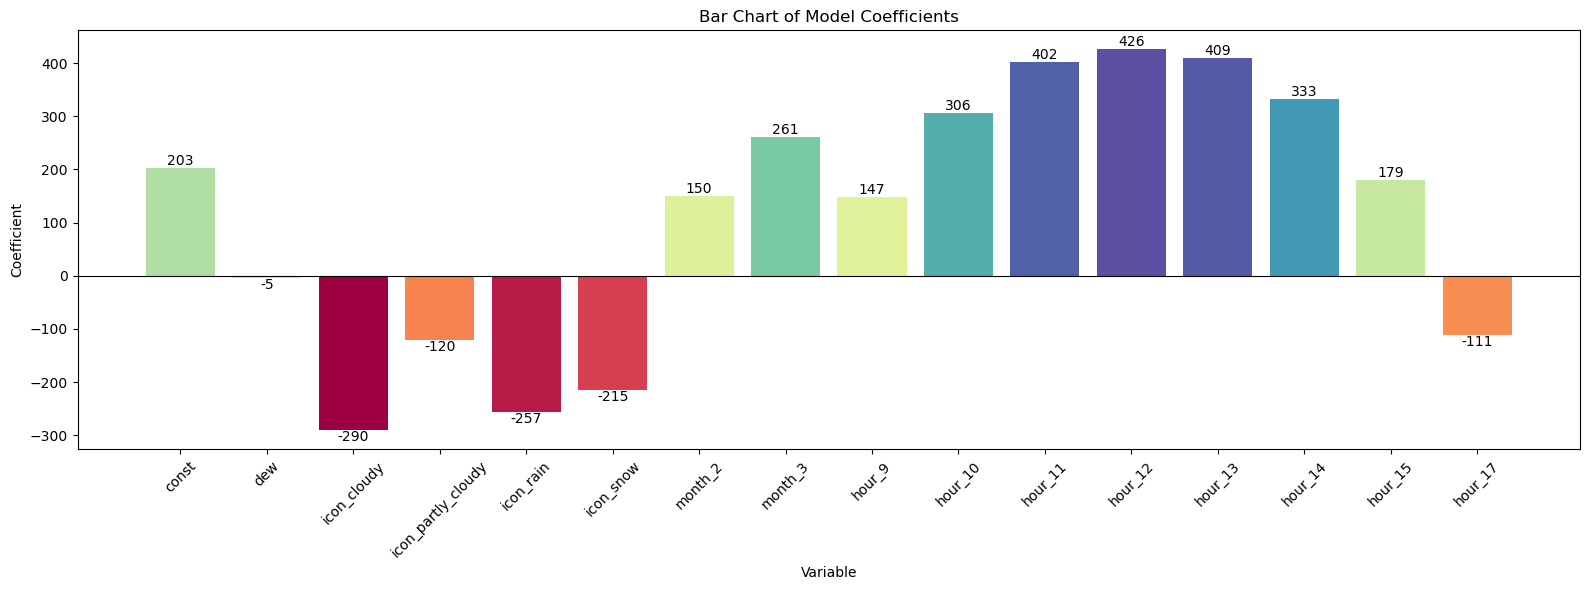

In [16]:
# Set color palette and normalize coefficients
cmap = sns.color_palette('Spectral', as_cmap = True)
norm = plt.Normalize(model_lr_summary['Coefficient'].min(), model_lr_summary['Coefficient'].max())
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])

# Map coefficients to colors
bar_colors = [cmap(norm(coef)) for coef in model_lr_summary['Coefficient']]

# Plot the bar chart
fig, ax = plt.subplots(figsize = (16, 6))
bars = ax.bar(model_lr_summary['Variable']
              , model_lr_summary['Coefficient']
              , color = bar_colors)

ax.axhline(0, color = 'black', linewidth = 0.8)
ax.set_xlabel('Variable')
ax.set_ylabel('Coefficient')
ax.set_title('Bar Chart of Model Coefficients')
ax.set_xticks(np.arange(len(model_lr_summary['Variable'])))
ax.set_xticklabels(model_lr_summary['Variable'], rotation = 45)

# Add labels to bars
for bar in bars:
    yval = bar.get_height()
    pos = 'bottom' if yval > 0 else 'top'
    ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.0f}', ha = 'center', va = pos, color = 'black')

# Adjust layout and save the plot
plt.tight_layout()
# plt.colorbar(sm, ax=ax, orientation='vertical', label='Coefficient Value')
plt.savefig('../image/lr_coeff.png', dpi=300, bbox_inches='tight')
plt.show();

#### Random Forest Regressor
- The default model has an R-squared of 0.97 on the training set and 0.80 on the testing set. Although it is overfitting, it performs better than ordinary linear regression.

In [17]:
# Set X, y
X = df.drop('solar', axis = 1)
y = df['solar']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [18]:
# Instantiate
rf = RandomForestRegressor()

# Fit
rf.fit(X_train, y_train)

# Predictions
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Calculate performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print results
print(f'Training RMSE: {train_rmse:.2f}')
print(f'Testing RMSE: {test_rmse:.2f}')
print(f'Training R-squared: {train_r2:.2f}')
print(f'Testing R-squared: {test_r2:.2f}')

Training RMSE: 43.44
Testing RMSE: 118.06
Training R-squared: 0.97
Testing R-squared: 0.81


#### Gradient Boost
- The default model shows an R-squared of 0.91 on the training set and 0.81 on the testing set, indicating less overfitting than the Random Forest Regressor.
- After tuning, the improved model achieves an R-squared of 1.00 on the training set and 0.90 on the testing set.
- The top three weather-related features influencing the model are `cloudcover`, `humidity`, and `has_solarradiation`.

In [19]:
# Set X, y
X = df.drop('solar', axis = 1)
y = df['solar']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [20]:
# Instantiate
gbr = GradientBoostingRegressor(random_state = 42)

# Fit
gbr.fit(X_train, y_train)

# Predictions
y_train_pred = gbr.predict(X_train)
y_test_pred = gbr.predict(X_test)

# Calculate performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print results
print(f'Training RMSE: {train_rmse:.2f}')
print(f'Testing RMSE: {test_rmse:.2f}')
print(f'Training R-squared: {train_r2:.2f}')
print(f'Testing R-squared: {test_r2:.2f}')

Training RMSE: 81.79
Testing RMSE: 119.74
Training R-squared: 0.91
Testing R-squared: 0.81


In [21]:
# Tuning via GridSearchCV
# Define the parameter grid
param_grid = {
    'n_estimators': [450, 500]
    , 'learning_rate': [0.08,0.09,0.1]
    , 'max_depth': [None]
    , 'min_samples_split': [35, 40, 45]
    , 'min_samples_leaf': [25, 30, 50]
    , 'subsample': [0.85, 0.9, 0.95]
}


# Instantiate
gbr = GradientBoostingRegressor(random_state = 42)

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator = gbr
                           , param_grid = param_grid
                           , cv = 5
                           , scoring ='r2'
                           , n_jobs = -1
                           , verbose = 2
                          )

# Fit
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the results
print(f'Best Parameters: {best_params}')
print(f'Best Cross-Validation Score: {best_score:.2f}')

# Train the Gradient Boosting model with the best parameters
best_gbr = grid_search.best_estimator_
best_gbr.fit(X_train, y_train)

# Predictions
y_train_pred = best_gbr.predict(X_train)
y_test_pred = best_gbr.predict(X_test)

# Calculate performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print results
print(f'Training RMSE: {train_rmse:.2f}')
print(f'Testing RMSE: {test_rmse:.2f}')
print(f'Training R-squared: {train_r2:.2f}')
print(f'Testing R-squared: {test_r2:.2f}')

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters: {'learning_rate': 0.08, 'max_depth': None, 'min_samples_leaf': 30, 'min_samples_split': 35, 'n_estimators': 500, 'subsample': 0.9}
Best Cross-Validation Score: 0.87
Training RMSE: 12.34
Testing RMSE: 85.43
Training R-squared: 1.00
Testing R-squared: 0.90


In [22]:
importances = best_gbr.feature_importances_
# importances

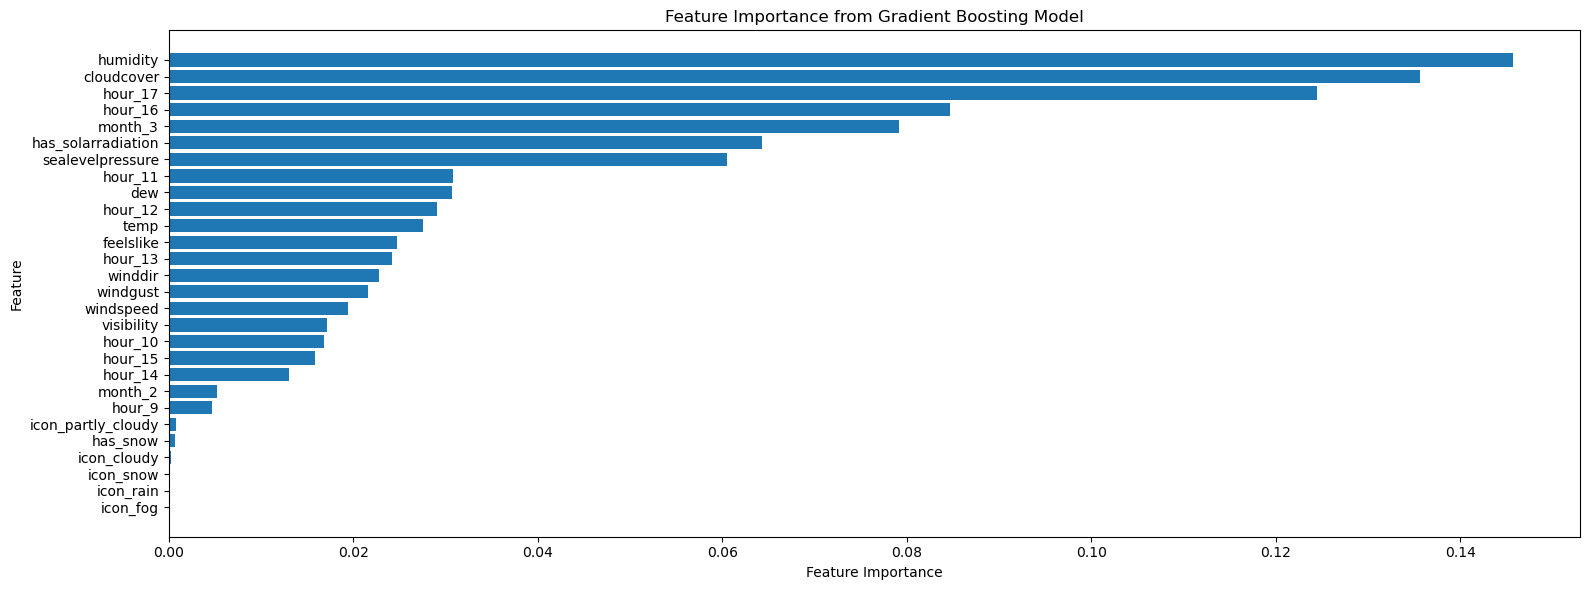

In [23]:
feature_names = X_train.columns

# Plot feature importances
plt.figure(figsize=(16, 6))
indices = np.argsort(importances)
plt.barh(range(len(importances)), importances[indices], align = 'center')
plt.yticks(range(len(importances)), feature_names[indices])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Gradient Boosting Model')
# Adjust layout
plt.tight_layout()
# Save
plt.savefig('../image/gb_importances.png', dpi = 300, bbox_inches = 'tight')
# Show the plot
plt.show();

In [24]:
# Save the best model
best_model = best_gbr
filename = '../model/solar_energy.pkl'

with open(filename, 'wb') as file:
    pickle.dump(best_model, file)
    
print(f'Model saved to {filename}')

Model saved to ../model/solar_energy.pkl
